<img src="https://uk-scape.ceh.ac.uk/sites/default/files/images/theme/UK_SCAPE_Logo_Positive_0.png" alt="image" align="left">

# Environment Agency water quality data access

This notebook enables you to retrieve a list of water quality sites within a defined radius of a lat/lng location from the EA's API, plot them on a map and then plot the timeseries for a chosen sampling location. \
Node middleware defined below is https://eip.ceh.ac.uk/hydrology-ukscape/help.

## Import packages
Import libraries for sites and plot 

In [1]:
import urllib.request
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# for map backgrounds
import contextily as cx 

## Get WQ sites
Function *get_wq_sites*: Load in the EA WQ sites from the node middleware to a geopandas dataframe. \
Retrieve the WQ sites based on entering a latitude, longitude and radius in km.

In [2]:
def get_wq_sites():
    #choose latitude, longitude and radius via input boxes
    latitude = input('Latitude')
    longitude = input('Longitude')
    radius = input('Radius (km)')
    # this is the node middleware
    url = "https://eip.ceh.ac.uk/hydrology-ukscape/stations/EA/WQ?dist="+str(radius)+"&latitude="+str(latitude)+"&longitude="+str(longitude)
    print('Site data URL:', url)
    sites = dict()
    try:
        #open the url with urllib.request
        with urllib.request.urlopen(url) as response:
            data = json.load(response)
            #print(data['data'])
            #create a pandas dataframe of the data array
            sites['df'] = pd.DataFrame(data['data']);
            #print(sites['df'])
            #convert to geopandas dataframe so can use the geometry to make a map
            sites['gdf'] = gpd.GeoDataFrame(sites['df'], geometry=gpd.points_from_xy(sites['df'].longitude, sites['df'].latitude))
            print(sites['gdf'].head(5))
            return sites
    except urllib.error.HTTPError as e:
        return sites
        print('get_wq_sites error', e.code)
        print('No sites available for this query.')  

## Get water quality sites around a point
- Function *get_timeseries_data*: fetch the data to plot the timeseries and then draw the plot. This function calls the two functions below.
- Function *get_determinands_for_site*: retrieve all the available determinands for an input site so you can choose what timeseries you'd like to plot
- Function *fetch_timeseries_data*: get the timeseries data of a site by it's reference

In [3]:
#get timeseries data for a given site_id
def get_timeseries_data(site_id):
    #get a list of available determinands for the given site
    determinands = get_determinands_for_site(site_id)
    timeseries_df = None
    determinand = dict()
    if len(determinands) > 0:
        #get the timeseries data by inputting a site ID from the site list and a determinand ID ('notation').
        determinand_id = input("Determinand ID (choose 'notation' from list above)")
        print(determinand_id)
        determinand['id'] = determinand_id
        #get determinand info from determinands list
        determinandQuery = determinands.query('notation == @determinand_id')
        del determinand_id
        if len(determinandQuery == 1):
            determinand['units'] = determinandQuery.values[0][4]['label']
            determinand['name'] = determinandQuery.values[0][2]
            print('site_id: '+site_id)
            print('determinand: '+str(determinand))
            timeseries_df = fetch_timeseries_data(site_id, determinand['id'])
    return {'data':timeseries_df, 'determinand':determinand}

#get all determinands for a site_id so can choose what to plot.
def get_determinands_for_site(site_id):
    detUrl = "https://environment.data.gov.uk/water-quality/id/sampling-point/"+site_id+"/determinands.json"
    print('Determinands for site URL:', detUrl)
    determinands = None
    try:
        with urllib.request.urlopen(detUrl) as response:
            data = json.load(response)
            #print(data)
            #print(data['items'])
            determinands = pd.DataFrame(data['items'])
            print(determinands.head(5))
            #for item in data['items']:
             #   print('Name: '+item['definition']+', ID: '+item['notation'] + ', units: '+item['unit']['label'])
            return determinands
    except:
        print('Error, cannot fetch determinands, or no determinands for ID.')

#get the timeseries data of a site by it's reference
#See http://eip.ceh.ac.uk/hydrology-ukscape/help for all available parameter combinations
def fetch_timeseries_data(site_id, determinand_id):
    #print(site_id, determinand_id)
    #get the data from node middleware as csv
    url = 'http://eip.ceh.ac.uk/hydrology-ukscape/stations/EA/WQ/'+str(site_id)+'?determinand='+str(determinand_id)
    print(url)
    timeseries_df = None
    try:
        with urllib.request.urlopen(url) as response:
        #read json into dataframe
            data = json.load(response)
            timeseries_df = pd.DataFrame(data['data']);
            #print(timeseries_df.head(5))
            return timeseries_df
    except urllib.error.HTTPError as e:
        print(e.code)
        print('No timeseries data available for this query.')  

## Fetch the sites
Dialogue boxes will allow you to choose a latitude, longitude and radius. Try latitude=55.5, longitude=-3.4 and 50km radius.
A map should appear showing all the sites if any are available.

Latitude 55.4
Longitude -3.4
Radius (km) 40


Site data URL: https://eip.ceh.ac.uk/hydrology-ukscape/stations/EA/WQ?dist=40&latitude=55.4&longitude=-3.4
            id                                     name organisation  \
0   NE-RSN0516                      BLACK BURN AT B6341           EA   
1  NW-88006473  CARWINLEY BURN AT CARWINLEY HIGH BRIDGE           EA   
2  NW-88006466          BLACK LYNE AT BLACK LYNE BRIDGE           EA   
3  NW-88006471                KERSHOPE BURN AT NY483828           EA   
4  NW-88006456          WHITE LYNE AT WHITE LYNE BRIDGE           EA   

    latitude  longitude                   geometry  
0  55.391720  -3.331968  POINT (-3.33197 55.39172)  
1  55.049774  -2.927709  POINT (-2.92771 55.04977)  
2  55.052442  -2.790351  POINT (-2.79035 55.05244)  
3  55.137998  -2.824622  POINT (-2.82462 55.13800)  
4  55.049108  -2.788892  POINT (-2.78889 55.04911)  
15 site(s) available


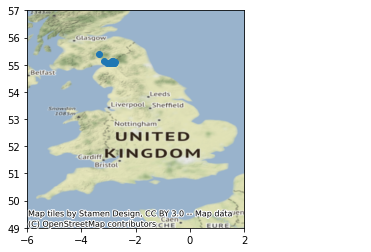

In [4]:
sites = get_wq_sites()
#plot sites on matplotlib
if 'gdf' in sites and not sites['gdf'].empty:
    print(len(sites['gdf']), 'site(s) available')
    ax = sites['gdf'].plot()
    ax.set_xlim([-6,2])
    ax.set_ylim([49,57])
    cx.add_basemap(ax, zoom=6, crs="epsg:4326")
else:
    print('No data')

## Draw a mapplotlib plot of timeseries data
Function *draw_Matplt_Plot*: draw a timeseries of x=datetime, y=values

In [5]:
from matplotlib import pyplot as matplt
import matplotlib.dates as mdate
def draw_Matplt_Plot(site_id, detStruct, df):
    fig = matplt.figure(figsize=(12,8))
    # plot x=datetime, y=values 
    matplt.plot(df['datetime'], df['value'])
    matplt.xlabel('Date')
    matplt.ylabel(detStruct['units'])
    matplt.title(detStruct['name'] + ' for ' + str(site_id))
    matplt.grid()
    #only show months on xaxis ticks
    locator = mdate.YearLocator()
    matplt.gca().xaxis.set_minor_locator(locator)
    matplt.gcf().autofmt_xdate()
    matplt.show()

## Get the timeseries data for a site ID
Choose an ID from the site list above. This will output some of the determinands available at this site. Then you can choose a determinand ID (notation) to plot a timeseries.

Site ID (choose from list above) NW-88006466


Determinands for site URL: https://environment.data.gov.uk/water-quality/id/sampling-point/NW-88006466/determinands.json
                                                 @id  \
0  http://environment.data.gov.uk/water-quality/d...   
1  http://environment.data.gov.uk/water-quality/d...   
2  http://environment.data.gov.uk/water-quality/d...   
3  http://environment.data.gov.uk/water-quality/d...   
4  http://environment.data.gov.uk/water-quality/d...   

                   definition         label notation  \
0                   Magnesium  Magnesium-Mg     0237   
1     Oxygen, Dissolved as O2   Oxygen Diss     9924   
2           Copper, Dissolved   Cu Filtered     6450   
3                    Chloride  Chloride Ion     0172   
4  Solids, Suspended at 105 C  Sld Sus@105C     0135   

                                                unit  
0  {'@id': 'http://environment.data.gov.uk/water-...  
1  {'@id': 'http://environment.data.gov.uk/water-...  
2  {'@id': 'http://environment.data.gov.

Determinand ID (choose 'notation' from list above) 9924


9924
site_id: NW-88006466
determinand: {'id': '9924', 'units': 'mg/l', 'name': 'Oxygen Diss'}
http://eip.ceh.ac.uk/hydrology-ukscape/stations/EA/WQ/NW-88006466?determinand=9924
   value             datetime                   materialType  \
0   14.3  2000-01-24T12:43:00  RIVER / RUNNING SURFACE WATER   
1   13.3  2000-02-16T14:40:00  RIVER / RUNNING SURFACE WATER   
2   12.1  2000-03-06T12:30:00  RIVER / RUNNING SURFACE WATER   
3   11.6  2000-05-08T13:05:00  RIVER / RUNNING SURFACE WATER   
4   10.9  2000-05-25T10:40:00  RIVER / RUNNING SURFACE WATER   

                                                  id              determinand  \
0  http://environment.data.gov.uk/water-quality/d...  Oxygen, Dissolved as O2   
1  http://environment.data.gov.uk/water-quality/d...  Oxygen, Dissolved as O2   
2  http://environment.data.gov.uk/water-quality/d...  Oxygen, Dissolved as O2   
3  http://environment.data.gov.uk/water-quality/d...  Oxygen, Dissolved as O2   
4  http://environment.data.gov.uk

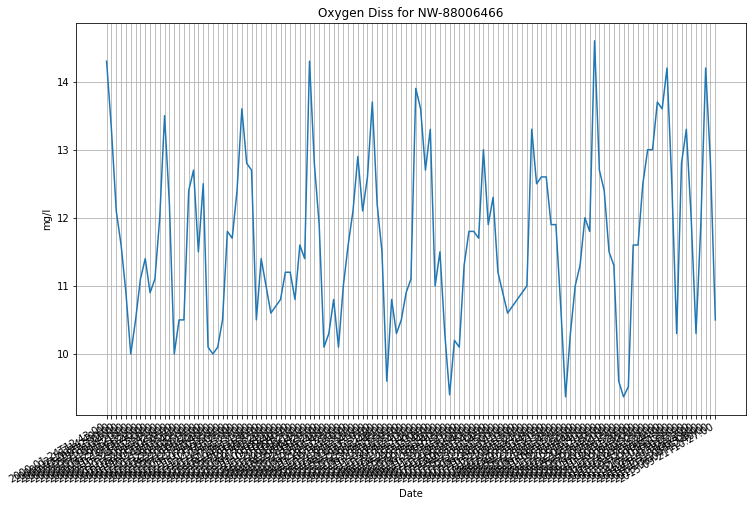

In [6]:
site_id = input('Site ID (choose from list above)')
ts_data = get_timeseries_data(site_id)
if (ts_data['data'] is not None and len(ts_data['data']) > 0):
    print(ts_data['data'].head(5))
    #if mapplotlib available
    draw_Matplt_Plot(site_id, ts_data['determinand'], ts_data['data'])
else:
    print('No timeseries data available for ' + str(site_id))